In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [2]:
%load_ext autoreload
%autoreload 2
#import CCPA_lib as cp
import sorf_lib as sf

In [3]:
sns.set_context('talk')
sns.set_style('white')


![](http://oregonstate.edu/instruct/bb450/fall14/stryer7/2/table_02_02.jpg)

https://www.uniprot.org/uniprot/Q7V735

http://tigrfams.jcvi.org/cgi-bin/HmmReportPage.cgi?acc=TIGR03798

https://www.ebi.ac.uk/training/online/course/interpro-functional-and-structural-analysis-protei/sequence-searching/searching-interpro-batc

http://www.ebi.ac.uk/interpro/sequencesearch/iprscan5-S20190707-131508-0462-76111813-p1m

https://www.ebi.ac.uk/Tools/services/rest/iprscan5/result/iprscan5-S20190707-131508-0462-76111813-p1m/json

In [4]:
oorder = ['Intergenic', 'Antisense', 'Out of Frame','In Frame',  'Annotated', ]
opalette = sns.color_palette("rainbow", 5).as_hex()
#del opalette[4]
genome='MIT9313'

In [5]:
found_sorf_df = pd.read_pickle('found_sorf_ISME16_David.pkl.gz')

In [6]:
found_sorf_df.shape

(213, 76)

# Gene Families

In [7]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(found_sorf_df['product'].value_counts())

hypothetical protein                                                  88
Nif11-like leader peptide family natural product precursor            23
                                                                      12
high light inducible protein                                           5
bacteriocin                                                            2
4a-hydroxytetrahydrobiopterin dehydratase                              2
DUF4278 domain-containing protein                                      2
DUF2839 domain-containing protein                                      1
PipX family protein                                                    1
photosystem I iron-sulfur center protein PsaC                          1
30S ribosomal protein S15                                              1
50S ribosomal protein L28                                              1
30S ribosomal protein S19                                              1
RNA-binding S4 domain-containing protein           

In [8]:
family_interaction = ['ProcA', 'CCRG-2', 'CCRG-1']
metabolism_products = [
    '2Fe-2S iron-sulfur cluster binding domain-containing protein',
    '4a-hydroxytetrahydrobiopterin dehydratase',
    'ATP synthase F0 subunit C',
       'NAD(P)H-quinone oxidoreductase subunit O',
    'glutaredoxin 3',
       'phosphoribosylformylglycinamidine synthase subunit PurS',
    'rubredoxin',
       'sulfur carrier protein ThiS',
       'sulfurtransferase TusA family protein',
]
translation_products = [
    'translation initiation factor IF-1',
       'Asp-tRNA(Asn)/Glu-tRNA(Gln) amidotransferase subunit GatC',    
]
nucleotide_products = [
       'BolA family transcriptional regulator',
       'CopG family transcriptional regulator',
       'response regulator transcription factor',
        'HU family DNA-binding protein',
        'DNA-directed RNA polymerase subunit omega',
       'RNA recognition motif-containing protein',
    'RNA-binding S4 domain-containing protein', 
        'YciI family protein',
]
interaction_products = [
    'bacteriocin',    
]
light_products = [
    'ssl1498 family light-harvesting-like protein',
     'ssl1498 family light-harvesting-like protein',
       'chlororespiratory reduction protein 7',
       'cytochrome b559 subunit beta', 
       'cytochrome b559 subunit alpha'
]

found_sorf_df['family2'] = found_sorf_df['family']

found_sorf_df.loc[found_sorf_df['product'].str.contains('ribosomal'), 'family2'] = 'Translation'
found_sorf_df.loc[found_sorf_df['product'].str.contains('photosystem'), 'family2'] = 'Photosynthesis & Light'
found_sorf_df.loc[found_sorf_df['product'].str.contains('hypothetical'), 'family2'] = 'Hypothetical'
found_sorf_df.loc[found_sorf_df['product'] == '', 'family2'] = 'N/A'
found_sorf_df.loc[found_sorf_df['product'].str.contains('domain-containing protein') &
                  found_sorf_df['product'].str.startswith('DUF') , 'family2'] = 'Hypothetical'
found_sorf_df.loc[found_sorf_df['product'].str.contains('family protein') &
                  found_sorf_df['product'].str.startswith('DUF') , 'family2'] = 'Hypothetical'
found_sorf_df.loc[found_sorf_df['product'].str.contains('high light inducible protein'), 'family2'] = 'Photosynthesis & Light'
found_sorf_df.loc[found_sorf_df['product'].str.contains('carboxysome'), 'family2'] = 'Photosynthesis & Light'

found_sorf_df.loc[found_sorf_df['product'].isin(light_products), 'family2'] = 'Photosynthesis & Light'
found_sorf_df.loc[found_sorf_df['product'].isin(interaction_products), 'family2'] = 'Interactions'
found_sorf_df.loc[found_sorf_df['product'].isin(metabolism_products), 'family2'] = 'Metabolism'
found_sorf_df.loc[found_sorf_df['product'].isin(translation_products), 'family2'] = 'Translation'
found_sorf_df.loc[found_sorf_df['product'].isin(nucleotide_products), 'family2'] = 'Nucleotide binding'


found_sorf_df.loc[found_sorf_df['family'].isin(family_interaction), 'family2'] = 'Interactions'
found_sorf_df.loc[found_sorf_df['family2'].isna(), 'family2'] = 'Other'





In [9]:
found_sorf_df.family.unique()

array([nan, 'ProcA', 'CCRG-2', 'CCRG-1'], dtype=object)

In [10]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', 100000):  # more options can be specified also
    #display(found_sorf_df.loc[found_sorf_df.family2.isna(), 'product'].value_counts())    
    display(found_sorf_df.loc[found_sorf_df.family2.isna(), 'product'].sort_values().reset_index(drop=True))

Series([], Name: product, dtype: object)

In [11]:
found_sorf_df.groupby(['family2'])['product'].value_counts()

family2       product                                                  
Hypothetical  hypothetical protein                                         86
              DUF4278 domain-containing protein                             2
              DUF1816 domain-containing protein                             1
              DUF2079 domain-containing protein                             1
              DUF2470 domain-containing protein                             1
                                                                           ..
Translation   50S ribosomal protein L33                                     1
              50S ribosomal protein L35                                     1
              50S ribosomal protein L36                                     1
              Asp-tRNA(Asn)/Glu-tRNA(Gln) amidotransferase subunit GatC     1
              translation initiation factor IF-1                            1
Name: product, Length: 87, dtype: int64

In [12]:
found_sorf_df.loc[found_sorf_df['family2'] == 'Other']['product'].value_counts().index.unique()

Index(['CbiX/SirB N-terminal domain-containing protein', 'PipX family protein',
       'acyl carrier protein',
       'UDP-2,4-diacetamido-2,4, 6-trideoxy-beta-L-altropyranose hydrolase',
       'chemotaxis protein', 'NifU family protein',
       'cupin domain-containing protein', 'Nif11 family protein',
       'BMC domain-containing protein', 'guanylate-binding protein',
       'ATP-dependent Clp protease adapter ClpS', 'YlxR family protein'],
      dtype='object')

# BLAST vs SORFS

In [13]:
def is_in_found_sorf(r):
    orfid = r.id.replace('lcl|','')
    return found_sorf_df.orfid.isin([orfid]).sum() > 0
    

In [14]:
accession = sf.get_accession(genome)
orf_dpath = 'orffinder_tmp'
orf_fpath = os.path.join(orf_dpath, f'{accession}.orffinder.fa')

In [15]:
found_sorf_df.aaseq.isna().sum()

0

In [16]:
from Bio import SeqIO
records = (r for r in SeqIO.parse(orf_fpath, "fasta") if is_in_found_sorf(r))

In [17]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
def _create_rec(orfid, aaseq):
    record = SeqRecord(Seq(aaseq, IUPAC.protein), id=orfid, description='unnamed protein product')
    return record
records = [
    _create_rec(orfid, aaseq) for (orfid, aaseq)
    in zip(found_sorf_df['orfid'],found_sorf_df['aaseq'])
]


In [18]:
out_fpath = os.path.join(orf_dpath, f'{genome}_found_proteome.fasta')
count = SeqIO.write(records, out_fpath, "fasta")
print("Saved %i records from %s to %s" % (count, orf_fpath, out_fpath))

Saved 213 records from orffinder_tmp\BX548175.orffinder.fa to orffinder_tmp\MIT9313_found_proteome.fasta


 mit9313_found_vs_pro_syn    https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Get&RID=8P2ACMPV014    
 mit9313_found_vs_nr         https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Get&RID=8P26YCM7014
 mit9313_found_vs_swisprot   https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Get&RID=8SHSH1FU014
 

In [19]:
blast_dpath = os.path.join('orffinder_tmp','blast results')
blast_vs_nr_dpath = os.path.join(blast_dpath, 'mit9313_found_vs_nr-Alignment.xml')
blast_vs_pro_dpath = os.path.join(blast_dpath, 'mit9313_found_vs_pro_syn-Alignment.xml')
blastn_vs_pro_dpath = os.path.join(blast_dpath, 'mit9313_blastn_vs_pro_syn-Alignment.xml')

blast_vs_sorf_dpath = os.path.join(blast_dpath, 'mit9313_sorf_all_vs_all-Alignment.xml')
blast_vs_swisprot_dpath = os.path.join(blast_dpath, 'mit9313_found_vs_swisprot-Alignment.xml')

os.listdir(blast_dpath)

['mit9313_blastn_vs_pro_syn-Alignment.xml',
 'mit9313_found_vs_pro_syn-Alignment.xml',
 'mit9313_found_vs_swisprot-Alignment.xml',
 'mit9313_sorf_all_vs_all-Alignment.xml',
 'old']

In [20]:
from Bio.Blast import NCBIXML


# BLAST vs SORF

In [21]:
def blast_rec_to_dict(blast_rec):
    query_id = blast_rec.query.replace(' unnamed protein product','').replace('lcl|','')
    results = [{
        'query' : query_id,
        'aligment_id' : alignment.hit_def.split()[0].replace('lcl|', ''), 
        'alignment_def' : alignment.hit_def,
        'coverage': np.round(np.mean([hsp.align_length / blast_rec.query_length for hsp in alignment.hsps]), decimals=2),
        'identity': np.round(np.mean([hsp.identities / blast_rec.query_length for hsp in alignment.hsps]), decimals=2),
        
        }
        for alignment in blast_rec.alignments if alignment.hit_id != query_id
    ]
    return results

In [22]:
fh = open(blast_vs_sorf_dpath)
blast_records = NCBIXML.parse(fh)
reslist = [blast_rec_to_dict(b) for b in blast_records]
blast_vs_sorf_df = pd.DataFrame([i for lst in reslist for i in lst])

In [23]:
fh.close()

In [24]:
for query in blast_records:
    for alignment in query.alignments:
        for hsp in alignment.hsps:
            print('coverage', hsp.align_length / query.query_length)
            print('identitiy', hsp.identities/ hsp.align_length)

In [25]:
blast_vs_sorf_df.head()

,query,aligment_id,alignment_def,coverage,identity
0,ORF59_BX548175.1:26835:27080,ORF59_BX548175.1:26835:27080,ORF59_BX548175.1:26835:27080 unnamed protein p...,1.00,1.00
1,ORF395_BX548175.1:178002:178226,ORF395_BX548175.1:178002:178226,ORF395_BX548175.1:178002:178226 unnamed protei...,1.00,1.00
2,ORF2049_BX548175.1:913137:913382,ORF2049_BX548175.1:913137:913382,ORF2049_BX548175.1:913137:913382 unnamed prote...,1.00,1.00
3,ORF2049_BX548175.1:913137:913382,ORF18399_BX548175.1:1009005:1008772,ORF18399_BX548175.1:1009005:1008772 unnamed pr...,0.98,0.80
4,ORF2049_BX548175.1:913137:913382,ORF26372_BX548175.1:2236618:2236379,ORF26372_BX548175.1:2236618:2236379 unnamed pr...,0.93,0.75


In [26]:
def create_sorfs_cluster(blast_vs_sorf_df, cluster_sorfs):
    new_alignments = set(
        blast_vs_sorf_df.loc[blast_vs_sorf_df['query'].isin(cluster_sorfs), 'aligment_id'].unique()
    )
    new_queries = set(
        blast_vs_sorf_df.loc[blast_vs_sorf_df['aligment_id'].isin(cluster_sorfs), 'query'].unique()
    )
    if (new_alignments <= cluster_sorfs) and (new_queries <= cluster_sorfs):
        return cluster_sorfs
    else:
        new_cluster_sorfs = cluster_sorfs | new_alignments | new_queries
        return create_sorfs_cluster(blast_vs_sorf_df, new_cluster_sorfs)
    
    

In [27]:
def create_sorfs_cluster_sel_root(blast_vs_sorf_df, visited):
    not_visited = blast_vs_sorf_df.loc[~blast_vs_sorf_df['query'].isin(visited), 'query'].unique()
    if len(not_visited):
        return create_sorfs_cluster(blast_vs_sorf_df, {not_visited[0]})
    #else
    not_visited2 = blast_vs_sorf_df.loc[~blast_vs_sorf_df['aligment_id'].isin(visited), 'aligment_id'].unique()
    if len(not_visited2):
        return create_sorfs_cluster(blast_vs_sorf_df, {not_visited2[0]})
    # else
    return None
    


In [28]:
visited = set()
clusters = []
while(True):
    new_cluster = create_sorfs_cluster_sel_root(blast_vs_sorf_df, visited)
    if new_cluster is None:
        break
    visited = visited | new_cluster
    clusters.append(new_cluster)
    

In [29]:
len(clusters)

173

In [30]:
clusters

[{'ORF59_BX548175.1:26835:27080'},
 {'ORF395_BX548175.1:178002:178226'},
 {'AKG35_RS01285',
  'AKG35_RS01310',
  'AKG35_RS03215',
  'AKG35_RS04345',
  'AKG35_RS04370',
  'AKG35_RS04865',
  'ORF15620_BX548175.1:2243295:2243047',
  'ORF15637_BX548175.1:2235903:2235652',
  'ORF15638_BX548175.1:2235486:2235229',
  'ORF15639_BX548175.1:2235150:2234896',
  'ORF18399_BX548175.1:1009005:1008772',
  'ORF20045_BX548175.1:274995:274750',
  'ORF2049_BX548175.1:913137:913382',
  'ORF20960_BX548175.1:2244944:2244663',
  'ORF20982_BX548175.1:2236277:2236026',
  'ORF25353_BX548175.1:276446:276159',
  'ORF25455_BX548175.1:233492:233262',
  'ORF26353_BX548175.1:2243725:2243456',
  'ORF26370_BX548175.1:2237020:2236769',
  'ORF26372_BX548175.1:2236618:2236379',
  'ORF29176_BX548175.1:1009423:1009181',
  'ORF30806_BX548175.1:274552:274289',
  'ORF5422_BX548175.1:182116:182298',
  'ORF7032_BX548175.1:905452:905715'},
 {'ORF2068_BX548175.1:922530:922661'},
 {'ORF18490_BX548175.1:968157:967891', 'ORF2321_BX54

In [31]:
real_clusters = [i for i in clusters if len(i)>1]
for i,c in enumerate(real_clusters, start=1):
    found_sorf_df.loc[found_sorf_df.orfid.isin(c), 'cluster_id'] = i

In [32]:
len(real_clusters)

13

In [33]:
found_sorf_df.head()

,AAs,Coverage,Description,Gene,Unique Peptides,aa_len,aa_sequence,aa_sequence_overlap,aaseq,best log prob,...,stop,stop_overlap,stop_r,strand,strand_overlap,total_intensity,type,type_overlap,family2,cluster_id
57,81.0,41.97,>lcl|ORF59_BX548175.1:26835:27080 unnamed prot...,NaN,4.0,NaN,MTAQLVPDQQIDLRGTPCPINFIRCRLALEGLKDKERLQVDLDRGE...,MTAQLVPDQQIDLRGTPCPINFIRCRLALEGLKDKERLQVDLDRGE...,MTAQLVPDQQIDLRGTPCPINFIRCRLALEGLKDKERLQVDLDRGE...,1.58,...,27080,27081.0,27081.0,+,+,38856834.6,CDS,CDS,Metabolism,NaN
409,74.0,20.27,>lcl|ORF395_BX548175.1:178002:178226 unnamed p...,NaN,2.0,NaN,MKRLGYPLLSLAAPLLIVLAMLCLMHRQGSDRLQSIPAVLVGAGLI...,MKRLGYPLLSLAAPLLIVLAMLCLMHRQGSDRLQSIPAVLVGAGLI...,MKRLGYPLLSLAAPLLIVLAMLCLMHRQGSDRLQSIPAVLVGAGLI...,1.52,...,178226,178227.0,178227.0,+,+,3892032.4,CDS,CDS,Hypothetical,NaN
2286,81.0,35.80,>lcl|ORF2049_BX548175.1:913137:913382 unnamed ...,NaN,4.0,NaN,MSEEQLKAFIAKVQGDTSLQEQLKAEGADVVAIAKAAGFSITTEDL...,MSEEQLKAFIAKVQGDTSLQEQLKAEGADVVAIAKAAGFSITTEDL...,MSEEQLKAFIAKVQGDTSLQEQLKAEGADVVAIAKAAGFSITTEDL...,1.57,...,913382,913383.0,913383.0,+,+,70379248.9,CDS,CDS,Interactions,1.0
2317,43.0,27.91,>lcl|ORF2068_BX548175.1:922530:922661 unnamed ...,NaN,1.0,NaN,None,,MMGKTKQHKKLVSWAEKAELCATREEAQKLIRKAEKAHAKLES,1.52,...,922661,178459.0,NaN,+,+,22239742.8,None,regulatory,N/A,NaN
2647,53.0,58.49,>lcl|ORF2321_BX548175.1:1030986:1031147 unname...,NaN,6.0,NaN,None,,MLSKSITGMFGRRNKKDAPKEEPTETDLERGYRLAAAKQKEILKEL...,1.58,...,1031147,178459.0,NaN,+,+,78996078.4,None,regulatory,N/A,2.0


In [34]:
found_sorf_df.groupby(['cluster_id','family2'])['product'].value_counts()

cluster_id  family2                 product                                                   
1.0         Interactions            Nif11-like leader peptide family natural product precursor    23
                                    lantipeptide                                                   1
2.0         Hypothetical            hypothetical protein                                           1
            N/A                                                                                    1
3.0         Hypothetical            hypothetical protein                                           1
            Interactions            hypothetical protein                                           1
            Other                   guanylate-binding protein                                      1
4.0         Hypothetical            hypothetical protein                                           2
5.0         Photosynthesis & Light  high light inducible protein                                 

In [35]:
found_sorf_df.groupby(['cluster_id', 'otype', 'orfid', 'product', #'family'
                      ])['family'].unique().str.join(',').reset_index()

,cluster_id,otype,orfid,product,family
0,1.0,Annotated,AKG35_RS01285,Nif11-like leader peptide family natural produ...,ProcA
1,1.0,Annotated,AKG35_RS01310,Nif11-like leader peptide family natural produ...,ProcA
2,1.0,Annotated,AKG35_RS03215,Nif11-like leader peptide family natural produ...,ProcA
3,1.0,Annotated,AKG35_RS04345,Nif11-like leader peptide family natural produ...,ProcA
4,1.0,Annotated,AKG35_RS04370,Nif11-like leader peptide family natural produ...,ProcA
5,1.0,Annotated,AKG35_RS04865,Nif11-like leader peptide family natural produ...,ProcA
6,1.0,Annotated,ORF15620_BX548175.1:2243295:2243047,Nif11-like leader peptide family natural produ...,ProcA
7,1.0,Annotated,ORF15637_BX548175.1:2235903:2235652,Nif11-like leader peptide family natural produ...,ProcA
8,1.0,Annotated,ORF15638_BX548175.1:2235486:2235229,lantipeptide,ProcA
9,1.0,Annotated,ORF15639_BX548175.1:2235150:2234896,Nif11-like leader peptide family natural produ...,ProcA


In [36]:
found_sorf_df.loc[found_sorf_df.cluster_id.isna()]['otype'].value_counts()

Annotated     144
Intergenic     11
Antisense       5
Name: otype, dtype: int64

In [37]:
found_sorf_df.pivot_table(columns='otype', index='family2',aggfunc='count', values='orfid').sum()


otype
Annotated       195.0
Antisense         5.0
Intergenic       12.0
Out of Frame      1.0
dtype: float64

In [38]:
found_sorf_df.otype.value_counts()

Annotated       195
Intergenic       12
Antisense         5
Out of Frame      1
Name: otype, dtype: int64

# tBLASTn vs PRO /SYN genomes

In [39]:
def pro_blastn_to_description(blast_rec):
    query_id = blast_rec.query.replace(' unnamed protein product','').replace('lcl|','')
    results = [{
        'query' : query_id,
        'pro_syn' : a.hit_def,
        'pro_syn_accession' : d.accession,
        'pro_syn_hsps' : len(a.hsps),
        'pro_syn_coverage': np.round(np.mean([hsp.align_length / blast_rec.query_length for hsp in a.hsps]), decimals=2),
        'pro_syn_identity': np.round(np.mean([hsp.identities / blast_rec.query_length for hsp in a.hsps]), decimals=2),
        }
        for d,a in zip(blast_rec.descriptions, blast_rec.alignments)
    ]
    return results

In [40]:
fh = open(blastn_vs_pro_dpath)
blast_records = NCBIXML.parse(fh)
reslist = [pro_blastn_to_description(b) for b in blast_records]
blastn_vs_pro_df = pd.DataFrame([i for lst in reslist for i in lst])

In [41]:
fh.close()

In [42]:
blastn_vs_pro_df.head()

,query,pro_syn,pro_syn_accession,pro_syn_hsps,pro_syn_coverage,pro_syn_identity
0,ORF59_BX548175.1:26835:27080,Prochlorococcus marinus MIT9313 complete genome,BX548175,1,1.00,1.00
1,ORF59_BX548175.1:26835:27080,"Prochlorococcus marinus str. MIT 9303, complet...",CP000554,1,1.00,0.99
2,ORF59_BX548175.1:26835:27080,"Synechococcus sp. ROS8604 chromosome, complete...",CP047946,1,0.91,0.60
3,ORF59_BX548175.1:26835:27080,"Synechococcus sp. A15-28 chromosome, complete ...",CP047931,1,0.89,0.58
4,ORF59_BX548175.1:26835:27080,"Synechococcus sp. CC9311, complete genome",CP000435,1,0.93,0.57


In [43]:
grouped_blastn_vs_pro_df =  blastn_vs_pro_df.loc[
    ~blastn_vs_pro_df.pro_syn.str.contains('MIT9313')
    ].groupby(by='query').agg({'pro_syn': 'count', 'pro_syn_hsps': 'mean'}).reset_index()
grouped_blastn_vs_pro_df.rename(columns={
    'pro_syn': 'pro/syn genomes', 
    'pro_syn_hsps': 'mean pro/syn alignments', 
    'pro_syn_coverage': 'mean pro/syn coverage',
    'pro_syn_identity': 'mean pro/syn identity'},
                                inplace=True)

In [44]:
grouped_blastn_vs_9313_df =  blastn_vs_pro_df.loc[
    blastn_vs_pro_df.pro_syn.str.contains('MIT9313')
    ].groupby(by='query').agg({'pro_syn': 'count', 'pro_syn_hsps': 'mean'}).reset_index()
grouped_blastn_vs_9313_df.rename(columns={
    'pro_syn': 'mit9313', 
    'pro_syn_hsps': 'mit9313 alignments',
    'pro_syn_coverage': 'mean mit9313 coverage',
    'pro_syn_identity': 'mean mit9313 identity'},
                                inplace=True)

In [45]:
found_sorf_df = pd.merge(found_sorf_df, 
         grouped_blastn_vs_pro_df,
         left_on='orfid', right_on='query', how='left')

In [46]:
found_sorf_df = pd.merge(found_sorf_df, 
         grouped_blastn_vs_9313_df,
         left_on='orfid', right_on='query', how='left')

In [47]:
found_sorf_df.head()

,AAs,Coverage,Description,Gene,Unique Peptides,aa_len,aa_sequence,aa_sequence_overlap,aaseq,best log prob,...,type,type_overlap,family2,cluster_id,query_x,pro/syn genomes,mean pro/syn alignments,query_y,mit9313,mit9313 alignments
0,81.0,41.97,>lcl|ORF59_BX548175.1:26835:27080 unnamed prot...,NaN,4.0,NaN,MTAQLVPDQQIDLRGTPCPINFIRCRLALEGLKDKERLQVDLDRGE...,MTAQLVPDQQIDLRGTPCPINFIRCRLALEGLKDKERLQVDLDRGE...,MTAQLVPDQQIDLRGTPCPINFIRCRLALEGLKDKERLQVDLDRGE...,1.58,...,CDS,CDS,Metabolism,NaN,ORF59_BX548175.1:26835:27080,82.0,1.000000,ORF59_BX548175.1:26835:27080,1.0,1.0
1,74.0,20.27,>lcl|ORF395_BX548175.1:178002:178226 unnamed p...,NaN,2.0,NaN,MKRLGYPLLSLAAPLLIVLAMLCLMHRQGSDRLQSIPAVLVGAGLI...,MKRLGYPLLSLAAPLLIVLAMLCLMHRQGSDRLQSIPAVLVGAGLI...,MKRLGYPLLSLAAPLLIVLAMLCLMHRQGSDRLQSIPAVLVGAGLI...,1.52,...,CDS,CDS,Hypothetical,NaN,ORF395_BX548175.1:178002:178226,27.0,1.000000,ORF395_BX548175.1:178002:178226,1.0,1.0
2,81.0,35.80,>lcl|ORF2049_BX548175.1:913137:913382 unnamed ...,NaN,4.0,NaN,MSEEQLKAFIAKVQGDTSLQEQLKAEGADVVAIAKAAGFSITTEDL...,MSEEQLKAFIAKVQGDTSLQEQLKAEGADVVAIAKAAGFSITTEDL...,MSEEQLKAFIAKVQGDTSLQEQLKAEGADVVAIAKAAGFSITTEDL...,1.57,...,CDS,CDS,Interactions,1.0,ORF2049_BX548175.1:913137:913382,13.0,26.692308,ORF2049_BX548175.1:913137:913382,1.0,34.0
3,43.0,27.91,>lcl|ORF2068_BX548175.1:922530:922661 unnamed ...,NaN,1.0,NaN,None,,MMGKTKQHKKLVSWAEKAELCATREEAQKLIRKAEKAHAKLES,1.52,...,None,regulatory,N/A,NaN,ORF2068_BX548175.1:922530:922661,28.0,1.000000,ORF2068_BX548175.1:922530:922661,1.0,1.0
4,53.0,58.49,>lcl|ORF2321_BX548175.1:1030986:1031147 unname...,NaN,6.0,NaN,None,,MLSKSITGMFGRRNKKDAPKEEPTETDLERGYRLAAAKQKEILKEL...,1.58,...,None,regulatory,N/A,2.0,ORF2321_BX548175.1:1030986:1031147,1.0,3.000000,ORF2321_BX548175.1:1030986:1031147,1.0,3.0


# blast vs pro syn

# blast vs swisprot

In [48]:
def swisprot_blast_to_description(blast_rec):
    query_id = blast_rec.query.replace(' unnamed protein product','').replace('lcl|','')
    results = [{
        'query' : query_id,
        'swis_description' : d.title.split('=', maxsplit=1)[-1],
        'swis_e' : d.e,
        'swis_coverage': np.round(np.mean([hsp.align_length / blast_rec.query_length for hsp in a.hsps]), decimals=2),
        'swis_identity': np.round(np.mean([hsp.identities / blast_rec.query_length for hsp in a.hsps]), decimals=2),
        
        }
        for d,a in zip(blast_rec.descriptions, blast_rec.alignments)
    ]
    return results

In [49]:
fh = open(blast_vs_swisprot_dpath)
blast_records = NCBIXML.parse(fh)
reslist = [swisprot_blast_to_description(b) for b in blast_records]
blast_vs_swis_df = pd.DataFrame([i for lst in reslist for i in lst])

In [50]:
found_sorf_df = pd.merge(found_sorf_df, 
         blast_vs_swis_df.loc[blast_vs_swis_df.groupby('query').swis_e.idxmin()].reset_index(drop=True),
         left_on='orfid', right_on='query', how='left')

In [51]:
found_sorf_df.otype.value_counts()

Annotated       195
Intergenic       12
Antisense         5
Out of Frame      1
Name: otype, dtype: int64

In [52]:
found_sorf_df.dropna(subset=['swis_description']).otype.value_counts()

Annotated       72
Out of Frame     1
Name: otype, dtype: int64

In [53]:
found_sorf_df.shape

(213, 89)

# Analysis

In [54]:
[(i,len(j)) for i,j in enumerate(real_clusters, start=1)]

[(1, 24),
 (2, 2),
 (3, 3),
 (4, 2),
 (5, 4),
 (6, 2),
 (7, 2),
 (8, 2),
 (9, 4),
 (10, 2),
 (11, 2),
 (12, 2),
 (13, 2)]

In [55]:
found_sorf_df.groupby(['cluster_id','family2'])['product'].value_counts()

cluster_id  family2                 product                                                   
1.0         Interactions            Nif11-like leader peptide family natural product precursor    23
                                    lantipeptide                                                   1
2.0         Hypothetical            hypothetical protein                                           1
            N/A                                                                                    1
3.0         Hypothetical            hypothetical protein                                           1
            Interactions            hypothetical protein                                           1
            Other                   guanylate-binding protein                                      1
4.0         Hypothetical            hypothetical protein                                           2
5.0         Photosynthesis & Light  high light inducible protein                                 

In [56]:
found_sorf_df.loc[found_sorf_df.cluster_id.isna() & ~found_sorf_df.family2.isin(['other'])].groupby(['family2'])['product'].value_counts()

family2       product                                                  
Hypothetical  hypothetical protein                                         73
              DUF4278 domain-containing protein                             2
              DUF1816 domain-containing protein                             1
              DUF2079 domain-containing protein                             1
              DUF2470 domain-containing protein                             1
                                                                           ..
Translation   50S ribosomal protein L33                                     1
              50S ribosomal protein L35                                     1
              50S ribosomal protein L36                                     1
              Asp-tRNA(Asn)/Glu-tRNA(Gln) amidotransferase subunit GatC     1
              translation initiation factor IF-1                            1
Name: product, Length: 76, dtype: int64

In [57]:
found_sorf_df.loc[found_sorf_df.cluster_id.isna() & found_sorf_df.family2.isin(['other'])]['product'].value_counts()

Series([], Name: product, dtype: int64)

In [58]:
found_sorf_df.loc[found_sorf_df.family2.isin(['other']), 'product'].value_counts()

Series([], Name: product, dtype: int64)

In [59]:
pd.set_option('display.max_colwidth', -1)
found_sorf_df.groupby(['cluster_id', 'otype', 'orfid', 'product', #'swis_description', #'family'
                      ])['family2'].unique().str.join(',').reset_index()

,cluster_id,otype,orfid,product,family2
0,1.0,Annotated,AKG35_RS01285,Nif11-like leader peptide family natural product precursor,Interactions
1,1.0,Annotated,AKG35_RS01310,Nif11-like leader peptide family natural product precursor,Interactions
2,1.0,Annotated,AKG35_RS03215,Nif11-like leader peptide family natural product precursor,Interactions
3,1.0,Annotated,AKG35_RS04345,Nif11-like leader peptide family natural product precursor,Interactions
4,1.0,Annotated,AKG35_RS04370,Nif11-like leader peptide family natural product precursor,Interactions
5,1.0,Annotated,AKG35_RS04865,Nif11-like leader peptide family natural product precursor,Interactions
6,1.0,Annotated,ORF15620_BX548175.1:2243295:2243047,Nif11-like leader peptide family natural product precursor,Interactions
7,1.0,Annotated,ORF15637_BX548175.1:2235903:2235652,Nif11-like leader peptide family natural product precursor,Interactions
8,1.0,Annotated,ORF15638_BX548175.1:2235486:2235229,lantipeptide,Interactions
9,1.0,Annotated,ORF15639_BX548175.1:2235150:2234896,Nif11-like leader peptide family natural product precursor,Interactions


In [60]:
found_sorf_df.loc[found_sorf_df.cluster_id.isna()]['otype'].value_counts()

Annotated     144
Intergenic    11 
Antisense     5  
Name: otype, dtype: int64

In [61]:
found_sorf_df.pivot_table(columns='otype', index='family2',aggfunc='count', values='orfid', margins=True).reset_index()

otype,family2,Annotated,Antisense,Intergenic,Out of Frame,All
0,Hypothetical,105.0,3.0,NaN,NaN,108
1,Interactions,28.0,NaN,NaN,1.0,29
2,Metabolism,10.0,NaN,NaN,NaN,10
3,N/A,NaN,NaN,12.0,NaN,12
4,Nucleotide binding,8.0,NaN,NaN,NaN,8
5,Other,10.0,2.0,NaN,NaN,12
6,Photosynthesis & Light,19.0,NaN,NaN,NaN,19
7,Translation,15.0,NaN,NaN,NaN,15
8,All,195.0,5.0,12.0,1.0,213


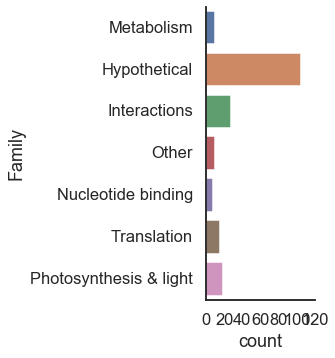

In [62]:
found_sorf_df['Family'] = found_sorf_df.family2.str.capitalize()
found_sorf_df.loc[found_sorf_df.Family.str.contains('Ccrg'), 'Family'] = 'Co Culture Related'
found_sorf_df.loc[found_sorf_df.Family.str.contains('Duf'), 'Family'] = 'Hypothetical'
found_sorf_df.loc[found_sorf_df.Family.str.contains('Carbox'), 'Family'] = 'Other'



sns.catplot(data=found_sorf_df.loc[found_sorf_df.otype.isin(['Annotated'])], y='Family', kind='count')

In [63]:
found_sorf_df.loc[found_sorf_df.otype.isin(['Annotated']) & found_sorf_df.Family.isin(['Other']), 'product'
                 ].value_counts().sort_index()


ATP-dependent Clp protease adapter ClpS    1
BMC domain-containing protein              1
Nif11 family protein                       1
NifU family protein                        1
PipX family protein                        1
YlxR family protein                        1
acyl carrier protein                       1
chemotaxis protein                         1
cupin domain-containing protein            1
guanylate-binding protein                  1
Name: product, dtype: int64

In [64]:
found_sorf_df.otype.value_counts()

Annotated       195
Intergenic      12 
Antisense       5  
Out of Frame    1  
Name: otype, dtype: int64

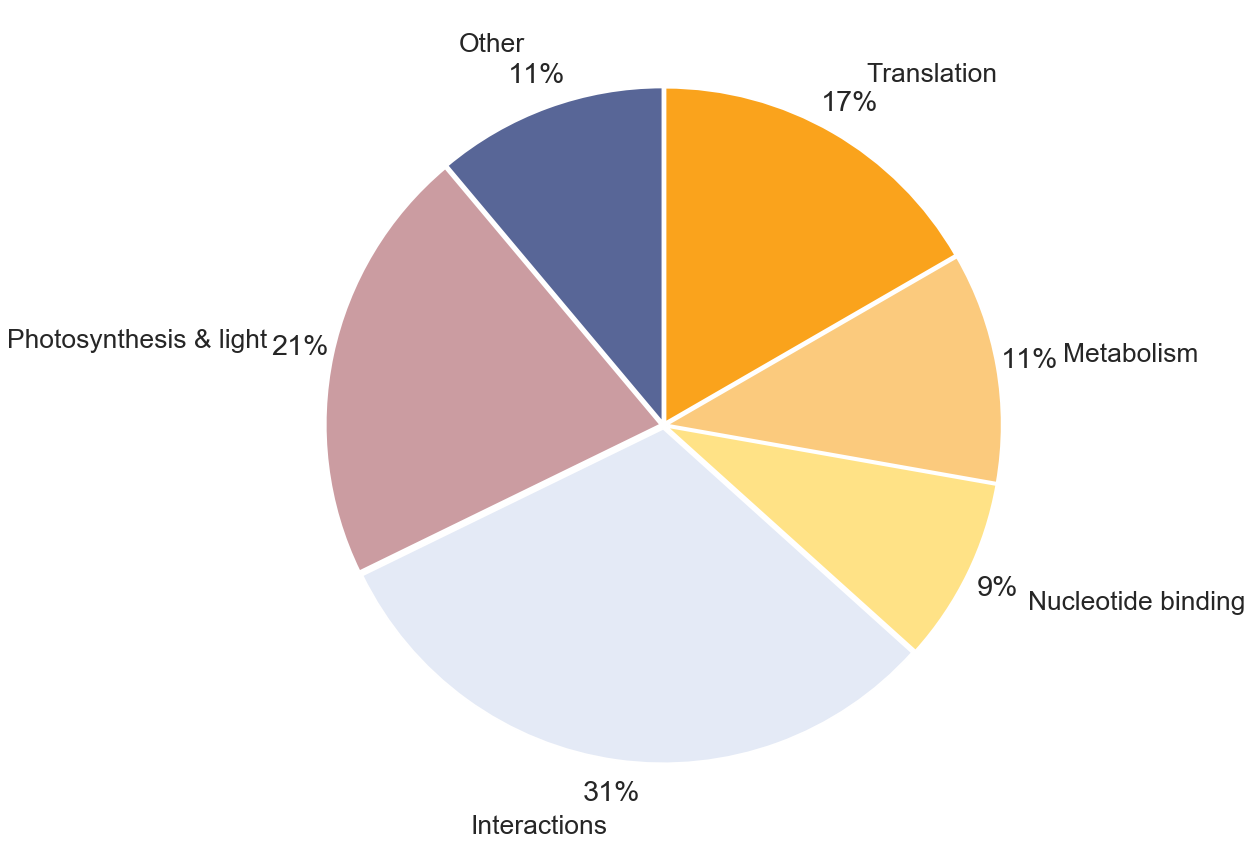

Text(0, 0.5, '')

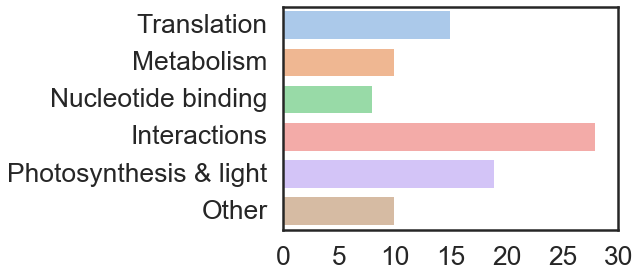

In [104]:
fig, ax = plt.subplots(figsize=(15,15))

pieorder = ['Translation','Metabolism', 'Nucleotide binding', 'Interactions', 'Photosynthesis & light', 'Other',
       ]
piepalette = ['#faa31c', '#fbca7d', '#ffe286', '#e4eaf6', '#cb9ca1', '#586697']
sns.set_context('poster', font_scale=1.2)
t = found_sorf_df.loc[found_sorf_df.otype.isin(['Annotated']) & ~found_sorf_df.Family.isin(['Hypothetical'])
                     ].groupby(['Family'])['otype'].count()
t = t.reindex(index=pieorder)
#t = t.sort_values(ascending=False)
plt.pie(t, labels=t.index,colors=piepalette, 
        autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2,
       startangle=90, counterclock=False, explode=(0.01,0.01,0.01,0.01,0.01,0.01)
       )
plt.show()
sns.barplot(y=t.index, x=t, palette='pastel')
plt.xlabel('')
plt.ylabel('')


In [92]:
t.index

Index(['Interactions', 'Photosynthesis & light', 'Translation', 'Other',
       'Metabolism', 'Nucleotide binding'],
      dtype='object', name='Family')

In [67]:
pd.set_eng_float_format()

In [68]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.precision', 0)
found_sorf_df.dropna(subset=['swis_description'])[['family2','otype', 'pro/syn genomes',
       'mean pro/syn alignments', 'product', 'swis_description', 'swis_e',
       'swis_coverage', 'swis_identity' ]]

,family2,otype,pro/syn genomes,mean pro/syn alignments,product,swis_description,swis_e,swis_coverage,swis_identity
2,Interactions,Annotated,13.000E+00,26.692E+00,Nif11-like leader peptide family natural product precursor,Lantipeptide prochlorosin 1.1; Short=Lantipeptide Pcn1.1; Flags: Precursor [Prochlorococcus marinus str. MIT 9313],0.000E-24,800.000E-03,730.000E-03
7,Nucleotide binding,Annotated,81.000E+00,1.000E+00,BolA family transcriptional regulator,Uncharacterized protein ssr3122 [Synechocystis sp. PCC 6803 substr. Kazusa],0.000E-24,1.000E+00,640.000E-03
15,Translation,Annotated,116.000E+00,1.000E+00,30S ribosomal protein S19,30S ribosomal protein S19 [Prochlorococcus marinus str. MIT 9303] >sp|Q7TUP5.1| RecName: Full=30S ribosomal protein S19 [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00
16,Translation,Annotated,86.000E+00,1.000E+00,50S ribosomal protein L29,50S ribosomal protein L29 [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00
19,Nucleotide binding,Annotated,82.000E+00,2.707E+00,response regulator transcription factor,Oxygen regulatory protein NreC; AltName: Full=Nitrogen regulation protein C [Staphylococcus aureus RF122] >sp|Q6GE42.1| RecName: Full=Oxygen regulatory protein NreC; AltName: Full=Nitrogen regulation protein C [Staphylococcus aureus subsp. aureus MRSA252],127.105E-12,610.000E-03,280.000E-03
24,Interactions,Annotated,10.000E+00,9.900E+00,Nif11-like leader peptide family natural product precursor,Lantipeptide prochlorosin 1.1; Short=Lantipeptide Pcn1.1; Flags: Precursor [Prochlorococcus marinus str. MIT 9313],10.984E-15,930.000E-03,520.000E-03
29,Translation,Annotated,113.000E+00,1.000E+00,30S ribosomal protein S15,30S ribosomal protein S15 [Prochlorococcus marinus str. MIT 9303] >sp|Q7TV07.1| RecName: Full=30S ribosomal protein S15 [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00
30,Translation,Annotated,110.000E+00,1.000E+00,30S ribosomal protein S18,30S ribosomal protein S18 [Prochlorococcus marinus str. MIT 9303] >sp|Q7TUZ8.1| RecName: Full=30S ribosomal protein S18 [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00
31,Translation,Annotated,108.000E+00,1.000E+00,50S ribosomal protein L32,50S ribosomal protein L32 [Prochlorococcus marinus str. MIT 9303] >sp|Q7V7I8.1| RecName: Full=50S ribosomal protein L32 [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00
32,Interactions,Out of Frame,13.000E+00,25.692E+00,Nif11-like leader peptide family natural product precursor,Lantipeptide prochlorosin 1.1; Short=Lantipeptide Pcn1.1; Flags: Precursor [Prochlorococcus marinus str. MIT 9313],0.000E-24,750.000E-03,660.000E-03


In [69]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.precision', 0)
found_sorf_df.dropna(subset=['swis_description']).loc[found_sorf_df.otype == 'Out of Frame',
      ['family2','otype', 'pro/syn genomes',
       'mean pro/syn alignments', 'product', 'swis_description', 'swis_e',
       'swis_coverage', 'swis_identity',
 'pro_syn_accession', 
                   'pro_syn_description','pro_syn_e', 'pro_syn_coverage',
       'pro_syn_identity', 'aa_sequence_overlap', 'aaseq'
      ]]

C:\Users\wosnat\Anaconda3\lib\site-packages\pandas\core\indexing.py:1404: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,family2,otype,pro/syn genomes,mean pro/syn alignments,product,swis_description,swis_e,swis_coverage,swis_identity,pro_syn_accession,pro_syn_description,pro_syn_e,pro_syn_coverage,pro_syn_identity,aa_sequence_overlap,aaseq
32,Interactions,Out of Frame,13.000E+00,25.692E+00,Nif11-like leader peptide family natural product precursor,Lantipeptide prochlorosin 1.1; Short=Lantipeptide Pcn1.1; Flags: Precursor [Prochlorococcus marinus str. MIT 9313],0.000E-24,750.000E-03,660.000E-03,NaN,NaN,NaN,NaN,NaN,,MSEEQLKAFIAKVQADASLQEQLRTEGADVVAIAKAAGFSITTEDLNSHRQNLSDDELEGVAGGGGKMTVRGRDMSCGCQDYWEDDY


In [70]:
found_sorf_df.columns

Index(['AAs', 'Coverage', 'Description', 'Gene', 'Unique Peptides', 'aa_len',
       'aa_sequence', 'aa_sequence_overlap', 'aaseq', 'best log prob',
       'best_score', 'contig', 'contig_id', 'contig_id_overlap', 'db_xref',
       'family', 'figfam', 'figfam_overlap', 'function', 'function_overlap',
       'gene_id', 'gene_id_overlap', 'genome', 'genome_overlap',
       'has unique peptides', 'is_downstream', 'is_inside', 'is_out_of_frame',
       'is_same_strand', 'is_upstream', 'left', 'left_overlap', 'left_r',
       'len_aa', 'len_aa3', 'len_nn', 'location', 'location_overlap',
       'log_prob', 'merge_location', 'mod_peptides', 'ms_detected',
       'multiple unique peptides', 'nucleotide_sequence',
       'nucleotide_sequence_overlap', 'num_spectra', 'old_locus_tag', 'orfid',
       'otype', 'overlap_count', 'overlap_gene_type', 'overlap_location',
       'overlap_strand', 'overlap_type', 'pmt_id', 'product', 'product_y',
       'protein_id', 'rast_left', 'rast_right', 'right',

In [71]:
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.precision', 0)
found_sorf_df.loc[found_sorf_df.otype.isin(['Intergenic', 'Antisense', 'Out of Frame']),
                  ['otype', 'orfid', #'mit9313 alignments','pro/syn genomes',
                   'strand', 
                  ]]

,otype,orfid,strand
3,Intergenic,ORF2068_BX548175.1:922530:922661,+
4,Intergenic,ORF2321_BX548175.1:1030986:1031147,+
32,Out of Frame,ORF7032_BX548175.1:905452:905715,+
35,Intergenic,ORF7224_BX548175.1:994741:994911,+
38,Intergenic,ORF7466_BX548175.1:1097200:1097379,+
54,Antisense,ORF9995_BX548175.1:2364358:2364552,+
60,Antisense,ORF12508_BX548175.1:1082192:1082350,+
72,Antisense,ORF14593_BX548175.1:2096789:2096866,+
73,Intergenic,ORF14768_BX548175.1:2186720:2186893,+
82,Intergenic,ORF16879_BX548175.1:1658121:1657948,-


In [72]:
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.precision', 0)
found_sorf_df.loc[found_sorf_df.otype.isin(['Out of Frame']),
                  ['orfid', #'mit9313 alignments','pro/syn genomes',
                   #'mean pro/syn alignments', 'pro_syn_accession', 
                   #'pro_syn_description','pro_syn_e', 'pro_syn_coverage',
       #'pro_syn_identity', 'cluster_id'
                   'function', 'product',
                   'strand',
                   'aaseq',
                   'gene_id_overlap','protein_id', 'overlap_location',
                   'aa_sequence_overlap',
                   'aa_sequence'
                  ]].T

# 905453..905716

,32
orfid,ORF7032_BX548175.1:905452:905715
function,None
product,Nif11-like leader peptide family natural product precursor
strand,+
aaseq,MSEEQLKAFIAKVQADASLQEQLRTEGADVVAIAKAAGFSITTEDLNSHRQNLSDDELEGVAGGGGKMTVRGRDMSCGCQDYWEDDY
gene_id_overlap,AKG35_RS04305
protein_id,
overlap_location,AKG35_RS04305
aa_sequence_overlap,
aa_sequence,None


In [73]:
1031011 - 1030986, 1031148- 1031147




(25, 1)

In [74]:
found_sorf_df.orfid.value_counts()

ORF14768_BX548175.1:2186720:2186893    1
ORF3964_BX548175.1:1838136:1838411     1
ORF9263_BX548175.1:2000086:2000235     1
ORF14128_BX548175.1:1850909:1851190    1
ORF27908_BX548175.1:1551703:1551524    1
                                      ..
ORF8845_BX548175.1:1802263:1802532     1
ORF22713_BX548175.1:1476551:1476351    1
ORF4165_BX548175.1:1957152:1957442     1
ORF9089_BX548175.1:1920028:1920321     1
ORF21723_BX548175.1:1905095:1904856    1
Name: orfid, Length: 213, dtype: int64

In [75]:
found_sorf_df.head()

,AAs,Coverage,Description,Gene,Unique Peptides,aa_len,aa_sequence,aa_sequence_overlap,aaseq,best log prob,...,mean pro/syn alignments,query_y,mit9313,mit9313 alignments,query,swis_description,swis_e,swis_coverage,swis_identity,Family
0,81.000E+00,41.970E+00,>lcl|ORF59_BX548175.1:26835:27080 unnamed protein product,NaN,4.000E+00,NaN,MTAQLVPDQQIDLRGTPCPINFIRCRLALEGLKDKERLQVDLDRGEPEAMVVPGLVEAGHRVEIIAQENTWLRLMVTCGGG,MTAQLVPDQQIDLRGTPCPINFIRCRLALEGLKDKERLQVDLDRGEPEAMVVPGLVEAGHRVEIIAQENTWLRLMVTCGGG,MTAQLVPDQQIDLRGTPCPINFIRCRLALEGLKDKERLQVDLDRGEPEAMVVPGLVEAGHRVEIIAQENTWLRLMVTCGGG,1.580E+00,...,1.000E+00,ORF59_BX548175.1:26835:27080,1.000E+00,1.000E+00,NaN,NaN,NaN,NaN,NaN,Metabolism
1,74.000E+00,20.270E+00,>lcl|ORF395_BX548175.1:178002:178226 unnamed protein product,NaN,2.000E+00,NaN,MKRLGYPLLSLAAPLLIVLAMLCLMHRQGSDRLQSIPAVLVGAGLIISGAVGRRRRRSKLLAALHSTQTEEQEH,MKRLGYPLLSLAAPLLIVLAMLCLMHRQGSDRLQSIPAVLVGAGLIISGAVGRRRRRSKLLAALHSTQTEEQEH,MKRLGYPLLSLAAPLLIVLAMLCLMHRQGSDRLQSIPAVLVGAGLIISGAVGRRRRRSKLLAALHSTQTEEQEH,1.520E+00,...,1.000E+00,ORF395_BX548175.1:178002:178226,1.000E+00,1.000E+00,NaN,NaN,NaN,NaN,NaN,Hypothetical
2,81.000E+00,35.800E+00,>lcl|ORF2049_BX548175.1:913137:913382 unnamed protein product,NaN,4.000E+00,NaN,MSEEQLKAFIAKVQGDTSLQEQLKAEGADVVAIAKAAGFSITTEDLNTHRQTLSDRELEGVAGGTTAFTGVDTESIAFCCS,MSEEQLKAFIAKVQGDTSLQEQLKAEGADVVAIAKAAGFSITTEDLNTHRQTLSDRELEGVAGGTTAFTGVDTESIAFCCS,MSEEQLKAFIAKVQGDTSLQEQLKAEGADVVAIAKAAGFSITTEDLNTHRQTLSDRELEGVAGGTTAFTGVDTESIAFCCS,1.570E+00,...,26.692E+00,ORF2049_BX548175.1:913137:913382,1.000E+00,34.000E+00,ORF2049_BX548175.1:913137:913382,Lantipeptide prochlorosin 1.1; Short=Lantipeptide Pcn1.1; Flags: Precursor [Prochlorococcus mari...,0.000E-24,800.000E-03,730.000E-03,Interactions
3,43.000E+00,27.910E+00,>lcl|ORF2068_BX548175.1:922530:922661 unnamed protein product,NaN,1.000E+00,NaN,None,,MMGKTKQHKKLVSWAEKAELCATREEAQKLIRKAEKAHAKLES,1.520E+00,...,1.000E+00,ORF2068_BX548175.1:922530:922661,1.000E+00,1.000E+00,NaN,NaN,NaN,NaN,NaN,N/a
4,53.000E+00,58.490E+00,>lcl|ORF2321_BX548175.1:1030986:1031147 unnamed protein product,NaN,6.000E+00,NaN,None,,MLSKSITGMFGRRNKKDAPKEEPTETDLERGYRLAAAKQKEILKELLAQKPRA,1.580E+00,...,3.000E+00,ORF2321_BX548175.1:1030986:1031147,1.000E+00,3.000E+00,NaN,NaN,NaN,NaN,NaN,N/a


In [76]:
blastn_vs_pro_df.loc[blastn_vs_pro_df['query'].str.contains('ORF2321_BX548175.1:1030986:1031147')]

,query,pro_syn,pro_syn_accession,pro_syn_hsps,pro_syn_coverage,pro_syn_identity
154,ORF2321_BX548175.1:1030986:1031147,Prochlorococcus marinus MIT9313 complete genome,BX548175,3,1.030E+00,840.000E-03
155,ORF2321_BX548175.1:1030986:1031147,"Prochlorococcus marinus str. MIT 9303, complete genome",CP000554,3,980.000E-03,770.000E-03


In [77]:
found_sorf_df.nlargest(10, ['pro/syn genomes'])

,AAs,Coverage,Description,Gene,Unique Peptides,aa_len,aa_sequence,aa_sequence_overlap,aaseq,best log prob,...,mean pro/syn alignments,query_y,mit9313,mit9313 alignments,query,swis_description,swis_e,swis_coverage,swis_identity,Family
15,91.000E+00,70.330E+00,>lcl|ORF3964_BX548175.1:1838136:1838411 unnamed protein product,NaN,12.000E+00,NaN,MGRSLKKGPFIADSLLRKLEKQNADDDKSVIKTWSRASTILPMMIGHTIAVHNGRSHVPVFITEQMVGHKLGEFAPTRTFKGHIKDKKGGR,MGRSLKKGPFIADSLLRKLEKQNADDDKSVIKTWSRASTILPMMIGHTIAVHNGRSHVPVFITEQMVGHKLGEFAPTRTFKGHIKDKKGGR,MGRSLKKGPFIADSLLRKLEKQNADDDKSVIKTWSRASTILPMMIGHTIAVHNGRSHVPVFITEQMVGHKLGEFAPTRTFKGHIKDKKGGR,1.600E+00,...,1.000E+00,ORF3964_BX548175.1:1838136:1838411,1.000E+00,1.000E+00,ORF3964_BX548175.1:1838136:1838411,30S ribosomal protein S19 [Prochlorococcus marinus str. MIT 9303] >sp|Q7TUP5.1| RecName: Full=30...,0.000E-24,1.000E+00,1.000E+00,Translation
63,88.000E+00,56.820E+00,>lcl|ORF13351_BX548175.1:1509413:1509679 unnamed protein product,NaN,6.000E+00,NaN,MAHKKGTGSTRNGRDSNSKRLGVKAYGGETVTAGSILIRQRGTSVLPGVNVGQGKDDTLFALTDGVVAFESIRRSLRNRKRISVVASS,MAHKKGTGSTRNGRDSNSKRLGVKAYGGETVTAGSILIRQRGTSVLPGVNVGQGKDDTLFALTDGVVAFESIRRSLRNRKRISVVASS,MAHKKGTGSTRNGRDSNSKRLGVKAYGGETVTAGSILIRQRGTSVLPGVNVGQGKDDTLFALTDGVVAFESIRRSLRNRKRISVVASS,3.150E+00,...,1.000E+00,ORF13351_BX548175.1:1509413:1509679,1.000E+00,1.000E+00,ORF13351_BX548175.1:1509413:1509679,50S ribosomal protein L27 [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00,Translation
69,88.000E+00,69.320E+00,>lcl|ORF14108_BX548175.1:1840259:1840525 unnamed protein product,NaN,16.000E+00,NaN,MALKERLGTVVSDKMDKTVVVAVENRFPHPIYQKTVSRTTRYKAHDAGNTCRVGDRVRITETRPLSRSKRWTVAEVLSHSPKAQEVST,MALKERLGTVVSDKMDKTVVVAVENRFPHPIYQKTVSRTTRYKAHDAGNTCRVGDRVRITETRPLSRSKRWTVAEVLSHSPKAQEVST,MALKERLGTVVSDKMDKTVVVAVENRFPHPIYQKTVSRTTRYKAHDAGNTCRVGDRVRITETRPLSRSKRWTVAEVLSHSPKAQEVST,1.580E+00,...,1.009E+00,ORF14108_BX548175.1:1840259:1840525,1.000E+00,1.000E+00,ORF14108_BX548175.1:1840259:1840525,30S ribosomal protein S17 [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00,Translation
70,93.000E+00,83.870E+00,>lcl|ORF14128_BX548175.1:1850909:1851190 unnamed protein product,NaN,16.000E+00,NaN,MPKPDIHPNWYPDAKVICNGEVVMTTGSTQPELHVDVWSGNHPFFTGTQKILDTEGRVDRFMRKYGMGSADAAADEKKPDAKNNNKDNTSKED,MPKPDIHPNWYPDAKVICNGEVVMTTGSTQPELHVDVWSGNHPFFTGTQKILDTEGRVDRFMRKYGMGSADAAADEKKPDAKNNNKDNTSKED,MPKPDIHPNWYPDAKVICNGEVVMTTGSTQPELHVDVWSGNHPFFTGTQKILDTEGRVDRFMRKYGMGSADAAADEKKPDAKNNNKDNTSKED,5.770E+00,...,1.000E+00,ORF14128_BX548175.1:1850909:1851190,1.000E+00,1.000E+00,ORF14128_BX548175.1:1850909:1851190,50S ribosomal protein L31 [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00,Translation
29,89.000E+00,74.160E+00,>lcl|ORF6596_BX548175.1:698671:698940 unnamed protein product,NaN,19.000E+00,NaN,MSLDTTEKQQLINANQTHGTDTGSVEVQVAMLSERITKLSSHLQENKHDFSSRQGLLKMIGRRKRLLSYVRGKSEQRYNGLITKLGIRG,MSLDTTEKQQLINANQTHGTDTGSVEVQVAMLSERITKLSSHLQENKHDFSSRQGLLKMIGRRKRLLSYVRGKSEQRYNGLITKLGIRG,MSLDTTEKQQLINANQTHGTDTGSVEVQVAMLSERITKLSSHLQENKHDFSSRQGLLKMIGRRKRLLSYVRGKSEQRYNGLITKLGIRG,2.420E+00,...,1.000E+00,ORF6596_BX548175.1:698671:698940,1.000E+00,1.000E+00,ORF6596_BX548175.1:698671:698940,30S ribosomal protein S15 [Prochlorococcus marinus str. MIT 9303] >sp|Q7TV07.1| RecName: Full=30...,0.000E-24,1.000E+00,1.000E+00,Translation
97,78.000E+00,75.640E+00,>lcl|ORF19047_BX548175.1:750573:750337 unnamed protein product,NaN,15.000E+00,NaN,MSRVCQLTGTRANNGMAVSHSHIRTKKLQQANLQQRRLWWAEGNRWLKLRVSTRALKTIQKKGLGVYAKSLGIDLNKI,MSRVCQLTGTRANNGMAVSHSHIRTKKLQQANLQQRRLWWAEGNRWLKLRVSTRALKTIQKKGLGVYAKSLGIDLNKI,MSRVCQLTGTRANNGMAVSHSHIRTKKLQQANLQQRRLWWAEGNRWLKLRVSTRALKTIQKKGLGVYAKSLGIDLNKI,1.580E+00,...,1.000E+00,ORF19047_BX548175.1:750573:750337,1.000E+00,1.000E+00,ORF19047_BX548175.1:750573:750337,50S ribosomal protein L28 [Prochlorococcus marinus str. MIT 9303] >sp|Q7V7P3.1| RecName: Full=50...,0.000E-24,1.000E+00,1.000E+00,Translation
168,65.000E+00,55.380E+00,>AKG35_RS00300 50S ribosomal protein L35,NaN,7.000E+00,65.00

In [78]:
found_sorf_df.nsmallest(10, ['pro/syn genomes'])

,AAs,Coverage,Description,Gene,Unique Peptides,aa_len,aa_sequence,aa_sequence_overlap,aaseq,best log prob,...,mean pro/syn alignments,query_y,mit9313,mit9313 alignments,query,swis_description,swis_e,swis_coverage,swis_identity,Family
4,53.000E+00,58.490E+00,>lcl|ORF2321_BX548175.1:1030986:1031147 unnamed protein product,NaN,6.000E+00,NaN,None,,MLSKSITGMFGRRNKKDAPKEEPTETDLERGYRLAAAKQKEILKELLAQKPRA,1.580E+00,...,3.000E+00,ORF2321_BX548175.1:1030986:1031147,1.000E+00,3.000E+00,NaN,NaN,NaN,NaN,NaN,N/a
5,84.000E+00,80.950E+00,>lcl|ORF2340_BX548175.1:1038120:1038374 unnamed protein product,NaN,9.000E+00,NaN,MYSLFDSVFDVPFGYSIPRDRVVVIPDSQYNKLRAQENERQVAKLEARKEHHSQVIERLNEQISELQAALPAAEPDKELAATKE,MYSLFDSVFDVPFGYSIPRDRVVVIPDSQYNKLRAQENERQVAKLEARKEHHSQVIERLNEQISELQAALPAAEPDKELAATKE,MYSLFDSVFDVPFGYSIPRDRVVVIPDSQYNKLRAQENERQVAKLEARKEHHSQVIERLNEQISELQAALPAAEPDKELAATKE,1.590E+00,...,6.000E+00,ORF2340_BX548175.1:1038120:1038374,1.000E+00,7.000E+00,NaN,NaN,NaN,NaN,NaN,Other
10,98.000E+00,35.710E+00,>lcl|ORF3835_BX548175.1:1762950:1763246 unnamed protein product,NaN,4.000E+00,NaN,MRFIEFLDQRFCNSQEIREINHRGISAGFDGFREVWELDYLYEHFEADIHEIIEETGYLDSDLKDEFDNEETLRMKLVWFAVSTYCLSRTDALVEAKD,MRFIEFLDQRFCNSQEIREINHRGISAGFDGFREVWELDYLYEHFEADIHEIIEETGYLDSDLKDEFDNEETLRMKLVWFAVSTYCLSRTDALVEAKD,MRFIEFLDQRFCNSQEIREINHRGISAGFDGFREVWELDYLYEHFEADIHEIIEETGYLDSDLKDEFDNEETLRMKLVWFAVSTYCLSRTDALVEAKD,1.520E+00,...,1.000E+00,ORF3835_BX548175.1:1762950:1763246,1.000E+00,1.000E+00,NaN,NaN,NaN,NaN,NaN,Hypothetical
20,51.000E+00,41.180E+00,>lcl|ORF4637_BX548175.1:2186205:2186360 unnamed protein product,NaN,3.000E+00,NaN,MSSSEKELDLRIDHLQKELALAEQERDILRAAKMQQKILMKLLKENPSRQV,MSSSEKELDLRIDHLQKELALAEQERDILRAAKMQQKILMKLLKENPSRQV,MSSSEKELDLRIDHLQKELALAEQERDILRAAKMQQKILMKLLKENPSRQV,1.520E+00,...,1.000E+00,ORF4637_BX548175.1:2186205:2186360,1.000E+00,1.000E+00,NaN,NaN,NaN,NaN,NaN,Hypothetical
33,51.000E+00,58.820E+00,>lcl|ORF7084_BX548175.1:929743:929898 unnamed protein product,NaN,2.000E+00,NaN,MRQSFAGTTGAVQPLATPRIQSIREKISIQELELRLTRLGLATTTHTPNPS,MRQSFAGTTGAVQPLATPRIQSIREKISIQELELRLTRLGLATTTHTPNPS,MRQSFAGTTGAVQPLATPRIQSIREKISIQELELRLTRLGLATTTHTPNPS,1.580E+00,...,1.000E+00,ORF7084_BX548175.1:929743:929898,1.000E+00,1.000E+00,NaN,NaN,NaN,NaN,NaN,Hypothetical
34,52.000E+00,73.080E+00,>lcl|ORF7163_BX548175.1:972145:972303 unnamed protein product,NaN,3.000E+00,NaN,MPSVKPRVGWIIDPELLSLLKELADKSGRTVPKEAEQAIKNWLQLHGNLPQD,MPSVKPRVGWIIDPELLSLLKELADKSGRTVPKEAEQAIKNWLQLHGNLPQD,MPSVKPRVGWIIDPELLSLLKELADKSGRTVPKEAEQAIKNWLQLHGNLPQD,1.580E+00,...,1.000E+00,ORF7163_BX548175.1:972145:972303,1.000E+00,1.000E+00,NaN,NaN,NaN,NaN,NaN,Hypothetical
35,56.000E+00,51.780E+00,>lcl|ORF7224_BX548175.1:994741:994911 unnamed protein product,NaN,2.000E+00,NaN,None,,MATLLQATGVELEPCLCEHCCQIRSQQKESQRVWQLPKFQSGCWQRLDLHHSSKAT,1.580E+00,...,1.000E+00,ORF7224_BX548175.1:994741:994911,1.000E+00,1.000E+00,NaN,NaN,NaN,NaN,NaN,N/a
36,61.000E+00,73.770E+00,>lcl|ORF7228_BX548175.1:995548:995733 unnamed protein product,NaN,5.000E+00,NaN,MNNTIKRTSVTRGLTNIHTIKLAVLDAIEYAEQRGDLNLALAYAALLKKDLDPLIKERLGL,MNNTIKRTSVTRGLTNIHTIKLAVLDAIEYAEQRGDLNLALAYAALLKKDLDPLIKERLGL,MNNTIKRTSVTRGLTNIHTIKLAVLDAIEYAEQRGDLNLALAYAALLKKDLDPLIKERLGL,1.580E+00,...,1.000E+00,ORF7228_BX548175.1:995548:995733,1.000E+00,1.000E+00,NaN,NaN,NaN,NaN,NaN,Hypothetical
39,38.000E+00,23.680E+00,>lcl|ORF7541_BX548175.1:1129495:1129611 unnamed protein product,NaN,1.000E+00,NaN,MILIVLLPILLAATWAFINIRGAALKQQGLGLVSKNKG,MILIVLLPILLAATWAFINIRGAALKQQGLGLVSKNKG,MILIVLLPILLAATWAFINIRGAALKQQGLGLVSKNKG,1.570E+00,...,1.000E+00,ORF7541_BX548175.1:1129495:1129611,1.000E+00,1.000E+00,ORF7541_BX548175.1:1129495:1129611,Photosystem II protein Y [Prochlorococcus marinus str. MIT 9313],408.579E-21,1.000E+00,1.000E+00,Photosynthesis & light
61,92.000E+00,46.740E+00,>lcl|ORF12615_BX548175.1:1123541:1123819 unnamed protein product,NaN,6.000E+00,NaN,MGRNVGDPIDPLDGAPKWMQRWLAPPIIWWRGVEDQQVSAIHALLLGGPALFVMILWFFGVNADPNGIGSVASCPAEWKCLGLGWLLNFSGA,MGRNVGDPIDPLDGAPKWMQRWLAPPIIWWRGVEDQQVSAIHALLLGGPALFVMILWFFGVNADPN

In [79]:
found_sorf_df.protein_id

0      WP_011129402.1
1      WP_011129537.1
2      WP_011130214.1
3                    
4                    
            ...      
208    WP_011130895.1
209    WP_041385121.1
210    WP_011130414.1
211    WP_011130358.1
212    WP_041384453.1
Name: protein_id, Length: 213, dtype: object

In [80]:
#sns.clustermap()
blastn_vs_pro_df.head()

,query,pro_syn,pro_syn_accession,pro_syn_hsps,pro_syn_coverage,pro_syn_identity
0,ORF59_BX548175.1:26835:27080,Prochlorococcus marinus MIT9313 complete genome,BX548175,1,1.000E+00,1.000E+00
1,ORF59_BX548175.1:26835:27080,"Prochlorococcus marinus str. MIT 9303, complete genome",CP000554,1,1.000E+00,990.000E-03
2,ORF59_BX548175.1:26835:27080,"Synechococcus sp. ROS8604 chromosome, complete genome",CP047946,1,910.000E-03,600.000E-03
3,ORF59_BX548175.1:26835:27080,"Synechococcus sp. A15-28 chromosome, complete genome",CP047931,1,890.000E-03,580.000E-03
4,ORF59_BX548175.1:26835:27080,"Synechococcus sp. CC9311, complete genome",CP000435,1,930.000E-03,570.000E-03


In [81]:
found_sorf_df.columns

Index(['AAs', 'Coverage', 'Description', 'Gene', 'Unique Peptides', 'aa_len',
       'aa_sequence', 'aa_sequence_overlap', 'aaseq', 'best log prob',
       'best_score', 'contig', 'contig_id', 'contig_id_overlap', 'db_xref',
       'family', 'figfam', 'figfam_overlap', 'function', 'function_overlap',
       'gene_id', 'gene_id_overlap', 'genome', 'genome_overlap',
       'has unique peptides', 'is_downstream', 'is_inside', 'is_out_of_frame',
       'is_same_strand', 'is_upstream', 'left', 'left_overlap', 'left_r',
       'len_aa', 'len_aa3', 'len_nn', 'location', 'location_overlap',
       'log_prob', 'merge_location', 'mod_peptides', 'ms_detected',
       'multiple unique peptides', 'nucleotide_sequence',
       'nucleotide_sequence_overlap', 'num_spectra', 'old_locus_tag', 'orfid',
       'otype', 'overlap_count', 'overlap_gene_type', 'overlap_location',
       'overlap_strand', 'overlap_type', 'pmt_id', 'product', 'product_y',
       'protein_id', 'rast_left', 'rast_right', 'right',

In [83]:
found_sorf_df['label'] = found_sorf_df['family2']
found_sorf_df.loc[
    found_sorf_df.otype.isin(['Antisense', 'Out of Frame', 'Intergenic']), 
    'label'
] = found_sorf_df.loc[
    found_sorf_df.otype.isin(['Antisense', 'Out of Frame', 'Intergenic']), 'otype'] 
row_col = found_sorf_df.groupby(['orfid'])['Family'].first()
row_col

col_pal = sns.color_palette('Set2', len(row_col.unique()))

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
col_pal = dict(zip(row_col.unique(), col_pal))

col_col = blastn_vs_pro_df['pro_syn']
def _pro_syn_to_type(x):
    x.contains('prochlorococcus')
 =  blastn_vs_pro_df['pro_syn'].str.contains('prochlorococcus', case=False)
tmpdf 

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 19)

In [ ]:
row_col

In [ ]:
blastn_vs_pro_df.loc[
    blastn_vs_pro_df['query'].isin(orfids_sorted) & 
    blastn_vs_pro_df['pro_syn'].str.contains(' gene'), 'pro_syn']


In [ ]:
sns.set_context('paper')
orfids_sorted =found_sorf_df.loc[found_sorf_df.otype.isin(['Annotated', 'Intergenic'])].sort_values(by='Family')['orfid']
blastn_vs_pro_df['log_hsps'] = np.log(blastn_vs_pro_df['pro_syn_hsps']+1)
pivotdf = blastn_vs_pro_df.loc[
    blastn_vs_pro_df['query'].isin(orfids_sorted) & 
    ~blastn_vs_pro_df['pro_syn'].str.contains(' gene') &
    ~blastn_vs_pro_df['pro_syn'].str.contains(' plasmid')
].pivot_table(columns=['pro_syn'], index='query', values=['log_hsps'],
                                      fill_value=0, 
                                      ).droplevel(0,axis=1)
pivotdf = pivotdf.reindex(index=orfids_sorted).dropna(axis='index')


row_colors = row_col[pivotdf.index].map(col_pal)

g = sns.clustermap(data=pivotdf, cmap='coolwarm', row_colors=row_colors,
                   row_cluster=False,# row_linkage=False,
                  linewidths=0, xticklabels=False, yticklabels=False)



for label in row_col.unique():
    g.ax_col_dendrogram.bar(0, 0, color=col_pal[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=6)
g.cax.set_position([.15, .2, .03, .45])


In [ ]:
sns.set_context('paper')
orfids_sorted =found_sorf_df.loc[found_sorf_df.otype.isin(['Annotated'])].sort_values(by='Family')['orfid']
blastn_vs_pro_df['log_hsps'] = np.log(blastn_vs_pro_df['pro_syn_hsps']+1)
pivotdf = blastn_vs_pro_df.loc[
    blastn_vs_pro_df['query'].isin(orfids_sorted) & 
    ~blastn_vs_pro_df['pro_syn'].str.contains(' gene') &
    ~blastn_vs_pro_df['pro_syn'].str.contains(' plasmid')
].pivot_table(columns=['pro_syn'], index='query', values=['log_hsps'],
                                      fill_value=0, 
                                      ).droplevel(0,axis=1)
pivotdf = pivotdf.reindex(index=orfids_sorted).dropna(axis='index')


row_colors = row_col[pivotdf.index].map(col_pal)

g = sns.clustermap(data=pivotdf.loc[:, (pivotdf >= 0).sum()>5], 
                   cmap='coolwarm', row_colors=row_colors,
                   row_cluster=False,# row_linkage=False,
                  linewidths=0, xticklabels=False, yticklabels=False)



for label in row_col.unique():
    g.ax_col_dendrogram.bar(0, 0, color=col_pal[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=6)
g.cax.set_position([.15, .2, .03, .45])


In [ ]:
pivotdf.shape

In [ ]:
found_sorf_df.otype.unique()

In [ ]:
orfids_sorted.str.contains('AK').sum()

In [ ]:
sns.set_context('paper')
blastn_vs_pro_df['log_hsps'] = np.log(blastn_vs_pro_df['pro_syn_hsps'])
pivotdf = blastn_vs_pro_df.loc[
    blastn_vs_pro_df['query'].isin(found_sorf_df['orfid']) & 
    ~blastn_vs_pro_df['pro_syn'].str.contains(' gene') &
    ~blastn_vs_pro_df['pro_syn'].str.contains(' plasmid')
].pivot_table(columns=['pro_syn'], index='query', values=['log_hsps'],
                                      fill_value=-1, 
                                      ).droplevel(0,axis=1)
row_colors = row_col[pivotdf.index].map(col_pal)

g = sns.clustermap(data=pivotdf, cmap='coolwarm', row_colors=row_colors,
                  linewidths=0, xticklabels=False, yticklabels=False)



for label in row_col.unique():
    g.ax_col_dendrogram.bar(0, 0, color=col_pal[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=6)
g.cax.set_position([.15, .2, .03, .45])


In [ ]:
pivotdf.loc[:, (pivotdf >= 0).sum()>5]

In [ ]:

g = sns.clustermap(data=pivotdf.loc[:, (pivotdf >= 0).sum()>5], 
                   cmap='coolwarm', row_colors=row_colors,
                  linewidths=0, xticklabels=False, yticklabels=False, #standard_scale=0
                  )



for label in row_col.unique():
    g.ax_col_dendrogram.bar(0, 0, color=col_pal[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=6)
g.cax.set_position([.15, .2, .03, .45])


In [ ]:
t = (pivotdf >= 0).sum()
t.nsmallest(20)

In [ ]:
t.index.str.contains('segment').sum()

In [ ]:
p = pivotdf.loc[found_sorf_df.loc[
    found_sorf_df.otype.isin(['Antisense', 'Out of Frame', 'Intergenic']), 'orfid']]
row_colors = row_col[p.index].map(col_pal)

g = sns.clustermap(data=p.loc[:, p.sum()>1], 
                   cmap='coolwarm', row_colors=row_col[p.index].map(col_pal), figsize=(15,15),
                  linewidths=0, #xticklabels=False, #yticklabels=False, #standard_scale=0
                  )



for label in row_col[p.index].unique():
    g.ax_col_dendrogram.bar(0, 0, color=col_pal[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=6)
g.cax.set_position([.15, .2, .03, .45])


In [ ]:
pivotdf.head()

In [ ]:
pivotdf.sum().sort_values().value_counts().sort_index()

In [ ]:
pivotdf.sum()>10

In [ ]:
pivotdf.droplevel(0,axis=1).index

In [ ]:
blastn_vs_pro_df.pro_syn_accession

In [ ]:
np.log(10)

In [ ]:
pivotdf.head()